# W266 Russian Troll Detection Project

# LSTM Notebook, Including Metadata

## Quick Status:  Tweet and User Metadata Incorporated; Variable Length LSTM enabled

This notebook takes the output of our Pre-Processing work (embedded tweet texts and metadata, see other notebooks) and runs it through an LSTM.

In [1]:
!cat /proc/meminfo | grep Mem

MemTotal:       16436324 kB
MemFree:        13011772 kB
MemAvailable:   15495064 kB


In [2]:
#Main Libraries
import numpy as np
from random import shuffle
import tensorflow as tf
import pandas as pd  
from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import (OneHotEncoder, StandardScaler)

import timeit  #For timing

#Accuracy reporting / plotting
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score)
import itertools
from collections import (defaultdict, OrderedDict)
from operator import itemgetter

/home/brandon_cummings/.local/lib/python3.5/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [3]:
#Plotting (re-running this cell causes long errors)
#import matplotlib
import matplotlib as mpl
mpl.use('Agg')  #Necessary to prevent display errors
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = 50

In [4]:
!cat /proc/meminfo | grep Mem

MemTotal:       16436324 kB
MemFree:        12898100 kB
MemAvailable:   15381440 kB


## Load and Shuffle Data

In [5]:
data_filename = 'data/df_mini_alltweets_with_embed.pkl'
df_alltweets = pd.read_pickle(data_filename)

#Remove all retweets
df_alltweets = df_alltweets[df_alltweets['retweeted_status_id'] == 0]

#Keep only retweets (must comment out line above, and must change train dev test cutoff points below)
#df_alltweets = df_alltweets[df_alltweets['retweeted_status_id'] != 0]

In [6]:
df_alltweets

,tweet_id,text,user_id,in_reply_to_status_id,retweeted_status_id,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions,target,statuses_count,followers_count,friends_count,favourites_count,listed_count,text_cantok,embedded_text
0,564839233957818369,"Either, we heal, now, as a team, or we will di...",0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[either, ,, we, heal, ,, now, ,, as, a, team, ...","[[0.32019, 0.081182, -0.080413, -0.0066426, -0..."
1,676409305944469504,RT @AmyMek: Shaker Aamer is not even a citizen...,0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[rt, <allcaps>, <user>, :, shaker, aamer, is, ...","[[0.68243, 0.73589, 0.017529, -0.13763, 0.3602..."
2,564822564556382208,https://t.co/5jtxjrQrKa just watch it),0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[<url>, just, watch, it, )]","[[0.55283, -0.57581, -0.76596, -1.1371, 0.2205..."
3,614985782739087360,"RT @_wintergirl93: Dude, seriously? Go away. h...",0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[rt, <allcaps>, <user>, :, dude, ,, seriously,...","[[0.68243, 0.73589, 0.017529, -0.13763, 0.3602..."
4,578247211655434240,What is he doing?? http://t.co/w19JHah4pV,0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[what, is, he, doing, ?, <repeat>, <url>]","[[0.71441, 0.46241, 0.028374, 0.07638, -0.0030..."
5,689503880091021312,RT @BringTheFlag: Iran to Begin Construction o...,0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[rt, <allcaps>, <user>, :, iran, to, begin, co...","[[0.68243, 0.73589, 0.017529, -0.13763, 0.3602..."
6,564830562670501888,"We turn, not older with years, but newer every...",0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[we, turn, ,, not, older, with, years, ,, but,...","[[0.70057, 1.2429, 0.14358, -0.047923, -0.2265..."
7,564821530824015873,To be able to say how much you love is to love...,0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[to, be, able, to, say, how, much, you, love, ...","[[0.54964, 0.032752, 0.19354, -0.51119, -0.394..."
8,673889392025600001,RT @keriqbaum: Mondays be like... https://t.co...,0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[rt, <allcaps>, <user>, :, mondays, be, like, ...","[[0.68243, 0.73589, 0.017529, -0.13763, 0.3602..."
9,554292771658268674,Literally why people voted for him http://t.co...,0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[literally, why, people, voted, for, him, <url>]","[[0.35106, 0.43278, 1.0263, -0.71624, -0.2855,..."


In [7]:
!cat /proc/meminfo | grep Mem

MemTotal:       16436324 kB
MemFree:        11013708 kB
MemAvailable:   13497092 kB


In [8]:
#Tweet Counts by Target Value
df_alltweets['target'].value_counts()

1    163810
0    102997
Name: target, dtype: int64

In [9]:
### NEW CELL
#Verify we've removed all retweets
df_alltweets[df_alltweets['retweeted_status_id'] != 0]

,tweet_id,text,user_id,in_reply_to_status_id,retweeted_status_id,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions,target,statuses_count,followers_count,friends_count,favourites_count,listed_count,text_cantok,embedded_text


In [10]:
df_alltweets.info(memory_usage='deep', verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266807 entries, 0 to 342856
Data columns (total 18 columns):
tweet_id                 266807 non-null int64
text                     266807 non-null object
user_id                  266807 non-null int64
in_reply_to_status_id    266807 non-null float64
retweeted_status_id      266807 non-null float64
retweet_count            266807 non-null float32
favorite_count           266807 non-null float32
num_hashtags             266807 non-null float32
num_urls                 266807 non-null float32
num_mentions             266807 non-null float64
target                   266807 non-null int8
statuses_count           266807 non-null float64
followers_count          266807 non-null float64
friends_count            266807 non-null float64
favourites_count         266807 non-null float64
listed_count             266807 non-null float64
text_cantok              266807 non-null object
embedded_text            266807 non-null object
dtypes: float32(4

In [11]:
#Shuffle the data
df_alltweets = df_alltweets.sample(frac=1, axis=0).reset_index(drop=True)
df_alltweets

,tweet_id,text,user_id,in_reply_to_status_id,retweeted_status_id,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions,target,statuses_count,followers_count,friends_count,favourites_count,listed_count,text_cantok,embedded_text
0,581954564653518851,It's cocktail hour (@ Stock &amp; Barrel in Da...,18581153,0.000000e+00,0.0,0.0,0.0,0.0,1.0,0.0,0,487.0,195.0,863.0,147.0,1.0,"[it, ', s, cocktail, hour, (, @, stock, &, amp...","[[-0.041101, 0.19113, 0.095499, 0.0028301, 0.0..."
1,576037241983627264,@JTxTS Yumyum ! http://t.co/31OAeqAXld,2283613500,5.760353e+17,0.0,0.0,0.0,0.0,0.0,1.0,0,2440.0,166.0,118.0,8468.0,0.0,"[<user>, yumyum, !, <url>]","[[0.78704, 0.72151, 0.29148, -0.056527, 0.3168..."
2,763782478586781697,Trump refuses to back away from false claim Ob...,2495567768,0.000000e+00,0.0,0.0,0.0,0.0,1.0,0.0,1,32546.0,16812.0,5128.0,1.0,159.0,"[trump, refuses, to, back, away, from, false, ...","[[-0.1166, 0.60989, 0.46737, 0.036106, 0.09880..."
3,712342117473857536,#StopIslam #IslamKills Just getting worse and ...,2572058134,0.000000e+00,0.0,0.0,0.0,1.0,0.0,0.0,1,1501.0,1545.0,1321.0,976.0,9.0,"[<hashtag>, stopislam, <hashtag>, islamkills, ...","[[1.0018, -0.76141, 0.11812, -1.3743, -0.41678..."
4,806301848542003200,RT @thesalteater: wow... https://t.co/R9s9KkLVN9,1680366068,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,1356.0,571.0,470.0,1365.0,7.0,"[rt, <allcaps>, <user>, :, wow, ., <repeat>, <...","[[0.68243, 0.73589, 0.017529, -0.13763, 0.3602..."
5,806450264278495232,RT @hervegg: L'étonnante inculture crasse du J...,1676481360,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,2170.0,1909.0,1501.0,1778.0,23.0,"[rt, <allcaps>, <user>, :, l, ', étonnante, in...","[[0.68243, 0.73589, 0.017529, -0.13763, 0.3602..."
6,573922016417484800,@whitesideschar you're supposed to keep it on ...,175418591,5.739218e+17,0.0,0.0,1.0,0.0,0.0,1.0,0,32096.0,3837.0,952.0,13755.0,13.0,"[<user>, you, ', re, supposed, to, keep, it, o...","[[0.78704, 0.72151, 0.29148, -0.056527, 0.3168..."
7,707744034102583296,More differences in #GOPDebate candidates than...,1623180199,0.000000e+00,0.0,0.0,0.0,1.0,0.0,0.0,1,2320.0,1565.0,1586.0,1090.0,18.0,"[more, differences, in, <hashtag>, gopd, <allc...","[[0.050098, -0.039769, -0.45337, 0.45028, 0.40..."
8,756849533443641344,RT @cnnbrk: Two ISIS fighters detonated suicid...,1649487510,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,1935.0,909.0,859.0,2026.0,13.0,"[rt, <allcaps>, <user>, :, two, isis, <allcaps...","[[0.68243, 0.73589, 0.017529, -0.13763, 0.3602..."
9,774255117927350272,US increases military presence in #Iraq by 460...,3899481526,0.000000e+00,0.0,15.0,1.0,1.0,1.0,0.0,1,10162.0,26430.0,6100.0,93.0,273.0,"[us, <allcaps>, increases, military, presence,...","[[0.51472, 0.59527, 0.031088, 0.31171, 0.09266..."


In [12]:
df_alltweets.info(memory_usage='deep', verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266807 entries, 0 to 266806
Data columns (total 18 columns):
tweet_id                 266807 non-null int64
text                     266807 non-null object
user_id                  266807 non-null int64
in_reply_to_status_id    266807 non-null float64
retweeted_status_id      266807 non-null float64
retweet_count            266807 non-null float32
favorite_count           266807 non-null float32
num_hashtags             266807 non-null float32
num_urls                 266807 non-null float32
num_mentions             266807 non-null float64
target                   266807 non-null int8
statuses_count           266807 non-null float64
followers_count          266807 non-null float64
friends_count            266807 non-null float64
favourites_count         266807 non-null float64
listed_count             266807 non-null float64
text_cantok              266807 non-null object
embedded_text            266807 non-null object
dtypes: float32(4

## Extract Tweet Text

In [13]:
#Extract just the values for the LSTM piece of the model
X = df_alltweets['embedded_text'].values
Y = df_alltweets['target'].values
print(X.shape)
print(X[0].shape)
print(X[1].shape)
print(X[2].shape)
print(Y)
print(Y.shape)

(266807,)
(19, 50)
(4, 50)
(13, 50)
[0 0 1 ... 1 1 0]
(266807,)


Looks like we're in good shape!  Har har har ...

In [14]:
#Pad / trim tweets
time_start = timeit.default_timer()

#First get their length
tweet_length_list = []
for tweet in X:
    tweet_length_list.append(len(tweet))

#Find the cutoff percentile (100 results in no trim)
cutoff_percentile = 99.5
print('Cutoff Percentile: ', cutoff_percentile)
cutoff_length = int(np.percentile(tweet_length_list, cutoff_percentile))
print('Cutoff Length: ', cutoff_length)

#Now pad / trim each tweet
for i, tweet in enumerate(X):
    if len(tweet) > cutoff_length:
        #Trim
        X[i] = X[i][0:cutoff_length]
    if len(tweet) < cutoff_length:        
        #Pad
        X[i] = np.vstack((X[i], np.zeros((cutoff_length - len(X[i]), 50))))
        
#Note, we're actually updating the 'embedded_text' valuues in the df_alltweets dataframe, 
    #giving it a MUCH bigger memory footprint.
    
#Timing
time_end = timeit.default_timer()
print('Time to run cell: {:.1f} seconds'.format(time_end - time_start))

Cutoff Percentile:  99.5
Cutoff Length:  40
Time to run cell: 7.0 seconds


In [15]:
X[1].shape

(40, 50)

In [16]:
#Convert to single array
# ### NOT SURE THIS IS THE BEST MANUEVER; SEEMS TO CONSUME MEMORY ... ###
X = np.stack(X)
print(X.shape)
print(Y.shape)

(266807, 40, 50)
(266807,)


In [17]:
#Convert labes to One Hot
y_hot = np.array(pd.get_dummies(Y))

print('Data shape: ', X.shape)
print('Label shape (original):', Y.shape)
print('Label shape (one hot):', y_hot.shape)
y_hot.view()

Data shape:  (266807, 40, 50)
Label shape (original): (266807,)
Label shape (one hot): (266807, 2)


array([[1, 0],
       [1, 0],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [1, 0]], dtype=uint8)

## Split Data into Train, Dev, Test

In [18]:
# Split test, dev, and training data.
cutoff_train_dev = 225000
cutoff_dev_test = 250000  #Shrinking this to potentially prevent TF errors calculating #incorrect
cutoff_test_end = 40000  #Setting this also helps prevent errors ... need to consider batches for post hoc analysis
truncate_test_data = False

if truncate_test_data == False:
    cutoff_test_end = None


train_data, train_labels = X[:cutoff_train_dev], y_hot[:cutoff_train_dev]
dev_data, dev_labels = X[cutoff_train_dev:cutoff_dev_test], y_hot[cutoff_train_dev:cutoff_dev_test]
test_data, test_labels = X[cutoff_dev_test:cutoff_test_end], y_hot[cutoff_dev_test:cutoff_test_end]

print(train_data[77].shape)
print(train_labels[77].shape)
print(train_data[77])
print(train_labels[77])

(40, 50)
(2,)
[[ 0.68243003  0.73588997  0.017529   ...  0.14771     0.080503
  -0.68115002]
 [ 1.12660003 -0.61615998 -0.70096999 ... -0.77548999 -0.71455002
  -0.49902999]
 [ 0.78704     0.72150999  0.29148    ...  0.080107   -0.075323
  -0.61461002]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[0 1]


In [19]:
print(train_data.shape)
print(dev_data.shape)
print(test_data.shape)
print(train_labels)
print(dev_labels)
print(test_labels)

(225000, 40, 50)
(25000, 40, 50)
(16807, 40, 50)
[[1 0]
 [1 0]
 [0 1]
 ...
 [0 1]
 [1 0]
 [1 0]]
[[1 0]
 [0 1]
 [0 1]
 ...
 [1 0]
 [0 1]
 [1 0]]
[[1 0]
 [0 1]
 [0 1]
 ...
 [0 1]
 [0 1]
 [1 0]]


### Generate sequence lengths

In [20]:
#Generate sequence lengths
sequence_lens = np.array(df_alltweets['text_cantok'].apply(len))
df_alltweets['seq_len_cantok'] = sequence_lens  #Also add it to the dataframe
sequence_lens = np.minimum(sequence_lens,cutoff_length)  #Max length to feed into model

#split seq_len into train, dev, test
sequence_lens_train = sequence_lens[0:cutoff_train_dev]
sequence_lens_dev = sequence_lens[cutoff_train_dev:cutoff_dev_test]
sequence_lens_test = sequence_lens[cutoff_dev_test:cutoff_test_end]

print(sequence_lens.shape)
print(sequence_lens_train.shape)
print(sequence_lens_dev.shape)
print(sequence_lens_test.shape)

sequence_lens

(266807,)
(225000,)
(25000,)
(16807,)


array([19,  4, 13, ..., 21, 30,  2])

## Explore Metadata

Commenting this whole section to save space.  But conclusions at the bottom still hold.

In [21]:
col_names = ['retweet_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions',
             'statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'listed_count',
             'seq_len_cantok', 'target'
            ]

#Just the culprit columns (plus 'target')
col_names = [
             'statuses_count', 'followers_count', 'friends_count', 'favourites_count',
             'target'
            ]

features = df_alltweets[col_names]
features[features['target'] == 0].describe(include='all')

,statuses_count,followers_count,friends_count,favourites_count,target
count,102997.000000,102997.000000,102997.000000,102997.000000,102997.0
mean,23957.988456,2471.973397,714.096741,5126.251638,0.0
std,35438.487031,30246.033248,1271.587525,9755.799802,0.0
min,15.000000,3.000000,1.000000,0.000000,0.0
25%,4774.000000,253.000000,224.000000,474.000000,0.0
50%,11539.000000,520.000000,419.000000,1892.000000,0.0
75%,26826.000000,1226.000000,801.000000,5599.000000,0.0
max,333504.000000,986837.000000,24691.000000,185467.000000,0.0


In [22]:
features[features['target'] == 1].describe(include='all')

,statuses_count,followers_count,friends_count,favourites_count,target
count,163810.000000,163810.000000,163810.000000,163810.000000,163810.0
mean,4430.265954,3955.193743,3029.389952,2305.166644,1.0
std,7113.673881,7732.520838,5071.618016,2825.242195,0.0
min,0.000000,0.000000,0.000000,0.000000,1.0
25%,1649.000000,909.000000,859.000000,939.000000,1.0
50%,2010.000000,1704.000000,1525.000000,1657.000000,1.0
75%,3379.000000,2464.000000,2658.000000,2420.000000,1.0
max,61735.000000,98412.000000,25600.000000,27181.000000,1.0


In [23]:
#Generate Plot Data
value_cols = list(set(col_names) - set({'target'}))
plot_data = pd.melt(features, id_vars=['target'], value_vars=value_cols)
plot_data.head()

,target,variable,value
0,0,followers_count,195.0
1,0,followers_count,166.0
2,1,followers_count,16812.0
3,1,followers_count,1545.0
4,1,followers_count,571.0


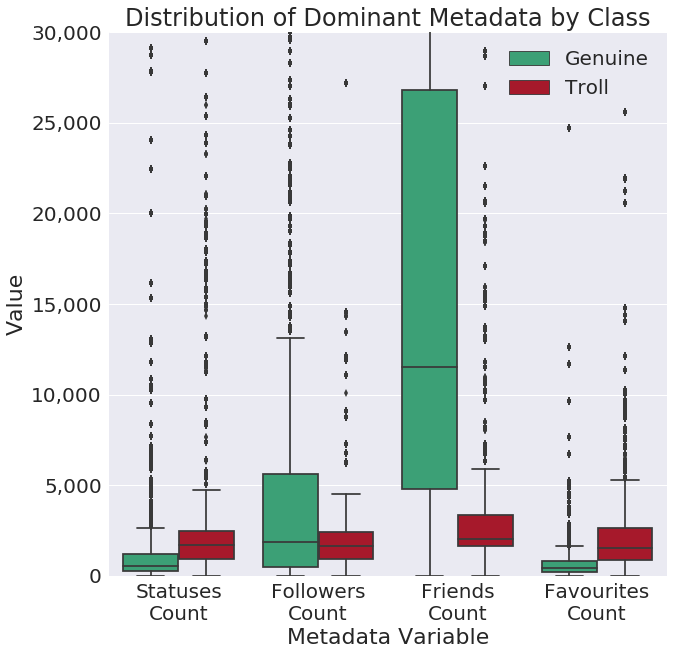

In [24]:

#sns.violinplot(x='variable', y='value', hue='target', data=plot_data)
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x='variable', y='value', hue='target', data=plot_data, palette=['#2bb179', '#be0119'])
plt.ylim(0, 30000)
ax.set_title('Distribution of Dominant Metadata by Class')
ax.set_xlabel('Metadata Variable')
ax.set_xticklabels(['Statuses\nCount','Followers\nCount', 'Friends\nCount','Favourites\nCount'])
ax.set_ylabel('Value')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
#ax.legend(labels=["A","B"])
L=plt.legend()
L.get_texts()[0].set_text('Genuine')
L.get_texts()[1].set_text('Troll')

sns.set(font_scale=1)


#Y ticks (commas)
#X ticks (words, not fields)
#Legend (0, 1 --> gen, troll)
#Legend placement
#Title
#X label
#Y label


## Extract and Scale Metadata

In [25]:
#Scale metadata columns
#Simpler, delete cell above once we verify it runs through
col_names = ['retweet_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions',
             'statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'listed_count',
             'seq_len_cantok'
            ]

#Testing the 'culprit columns'
col_names = ['statuses_count', 'followers_count', 'friends_count', 'favourites_count', 
            ]

#Testing the 'remaining columns'
# col_names = ['retweet_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions',
#              'listed_count',
#              'seq_len_cantok'
#             ]

print(col_names)
metadata = StandardScaler().fit_transform(df_alltweets[col_names].values)
meta_dim = metadata.shape[1]
print(metadata.shape)
metadata

['statuses_count', 'followers_count', 'friends_count', 'favourites_count']
(266807, 4)


array([[-0.46631003, -0.16133233, -0.30260175, -0.49218329],
       [-0.38699194, -0.16280009, -0.47974895,  0.76904168],
       [ 0.83571691,  0.67969049,  0.71153627, -0.5143127 ],
       ...,
       [-0.39795758, -0.07458303, -0.15089716, -0.24497046],
       [-0.39539893, -0.08495853, -0.16849299, -0.32121084],
       [-0.35913111, -0.15217153, -0.43219266, -0.27725515]])

In [26]:
#Split metadata
train_metadata = metadata[:cutoff_train_dev]
dev_metadata = metadata[cutoff_train_dev:cutoff_dev_test]
test_metadata = metadata[cutoff_dev_test:cutoff_test_end]

print(train_metadata.shape)
print(dev_metadata.shape)
print(test_metadata.shape)

(225000, 4)
(25000, 4)
(16807, 4)


In [27]:
cutoff_test_end

In [28]:
print(test_data.shape)
print(test_labels.shape)
print(test_metadata.shape)

(16807, 40, 50)
(16807, 2)
(16807, 4)


In [29]:
meta_dim

4

In [30]:
#!cat /proc/meminfo | grep Mem

## TensorFlow !

First, we'll build our model:

In [31]:
#Design the TF Model
tf.reset_default_graph() # fixes our reuse of variables problem

#Model parameters
epoch = 20  #Pretty good after 10 (with batch size = 500)
batch_size = 500
lrn_rate = 0.001  #Default is 0.001
ep = 1e-08  #Default is 1e-08
hidden_lstm_size = 32     #Research paper was 32
hidden_meta_h1_size = 128 #Research paper was 128
hidden_meta_h2_size = 64  #Research paper was 64


#Model inputs
#data = tf.placeholder(tf.float32, [None, cutoff_length, 50])  #[batch_size, max_seq_length, num_features]
target = tf.placeholder(tf.float32, [None, 2])    #[batch_size, output_length = num_classes]
meta = tf.placeholder(tf.float32, [None, meta_dim])    #[batch_size, meta_dim]

#BEFORE: data [bs, 27, 50] --> LSTM [bs, 34] --> Softmax [bs, 2]
#AFTER:  data [bs, 27, 50] --> LSTM [bs, 34] --> meta [bs, 34+meta_dim] --> Softmax [bs, 2]

#LSTM Layer
#seq_lens = tf.placeholder(tf.int32, [None])  #[batch_size]  #Sequence Lengths
#cell = tf.nn.rnn_cell.LSTMCell(hidden_lstm_size,state_is_tuple=True)
#val, state = tf.nn.dynamic_rnn(cell, data, sequence_length=seq_lens, dtype=tf.float32)

#Append metadata to LSTM end state (last) vector
#Remember, 'meta' is the tensor name, 'metadata' is the actual data we supply to feed_dict (when we execute below)
# use_meta = True
# if use_meta:
#     meta_last = tf.concat([state[1], meta], axis=1)
# else:
#     meta_last = state[1]
#     meta_dim = 0

#Post-LSTM Hidden Layer 1
weight_meta_h1 = tf.Variable(tf.truncated_normal([meta_dim, hidden_meta_h1_size]))  #[bs, 34+meta_dim, h1]
bias_meta_h1 = tf.Variable(tf.constant(0.1, shape=[hidden_meta_h1_size]))  #[bs, h1]
x_meta_h1 = tf.nn.relu(tf.matmul(meta, weight_meta_h1) + bias_meta_h1)

#Post-LSTM Hidden Layer 2
weight_meta_h2 = tf.Variable(tf.truncated_normal([hidden_meta_h1_size, hidden_meta_h2_size]))  #[bs, h1, h2]
bias_meta_h2 = tf.Variable(tf.constant(0.1, shape=[hidden_meta_h2_size]))  #[bs, h2]
x_meta_h2 = tf.nn.relu(tf.matmul(x_meta_h1, weight_meta_h2) + bias_meta_h2)

#Softmax Layer (final output)
#Note the weight dimension changed from hidden_lstm_size to hidden_lstm_size + meta_dim
weight_final = tf.Variable(tf.truncated_normal([hidden_meta_h2_size, int(target.get_shape()[1])]))  #[bs, hidden_meta_h1_size, 2]
bias_final = tf.Variable(tf.constant(0.1, shape=[target.get_shape()[1]]))  #[bs, 2]
prediction = tf.nn.softmax(tf.matmul(x_meta_h2, weight_final) + bias_final)

#Loss Function
cross_entropy = -tf.reduce_sum(target * tf.log(tf.clip_by_value(prediction,1e-10,1.0)))
optimizer = tf.train.AdamOptimizer(learning_rate=lrn_rate, epsilon=ep)
minimize = optimizer.minimize(cross_entropy)

mistakes = tf.not_equal(tf.argmax(target, axis=1), tf.argmax(prediction, axis=1))
error = tf.reduce_mean(tf.cast(mistakes, tf.float32))

In [32]:
#Execute the model!
time_start = timeit.default_timer()

init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

no_of_batches = int(len(train_data)/batch_size)
print("Number of batches: {}".format(no_of_batches))
for i in range(epoch):
    ptr = 0
    batch_num = 1
    for j in range(no_of_batches):
        batch_num+=1
        inp, out = train_data[ptr:ptr+batch_size], train_labels[ptr:ptr+batch_size]
        #seq_lens_batch = sequence_lens_train[ptr:ptr+batch_size]
        meta_inp = train_metadata[ptr:ptr+batch_size]
        ptr+=batch_size
        #feed_dict format = {tensor_name: data, tensor_name2: data2, etc.}
        sess.run(
            minimize,
            feed_dict=
            {
                #data: inp,
                target: out,
                #seq_lens: seq_lens_batch,
                meta: meta_inp
            }
        )
    
    print("Epoch -", str(i + 1), end='')
    incorrect = sess.run(error, {target: dev_labels, meta: dev_metadata})
    #incorrect = sess.run(error, {data: dev_data, target: dev_labels, seq_lens: sequence_lens_dev})
    print(': Error = {:3.2f}%.  '.format(100 * incorrect), end='')
    
    #Timing
    time_epoch = timeit.default_timer()
    print('Time to train {} epoch(s): {:.0f} seconds'.format(i+1, time_epoch - time_start))

#Running this at the end to manually test accuracy
#Recall, preds is a softmax, so floats, not ints
print('Fetch numerous tensors for post hoc analysis ... ', end='')

preds, targs = \
    sess.run([prediction, target], 
             {target: test_labels, meta: test_metadata}
             #{data: test_data, target: test_labels, seq_lens: sequence_lens_test}
            )
            

print('done!')

sess.close()

#Timing
time_end = timeit.default_timer()
print('Time to run cell: {:.0f} seconds'.format(time_end - time_start))

Number of batches: 450
Epoch - 1: Error = 2.06%.  Time to train 1 epoch(s): 2 seconds
Epoch - 2: Error = 1.58%.  Time to train 2 epoch(s): 3 seconds
Epoch - 3: Error = 1.49%.  Time to train 3 epoch(s): 5 seconds
Epoch - 4: Error = 1.51%.  Time to train 4 epoch(s): 7 seconds
Epoch - 5: Error = 1.35%.  Time to train 5 epoch(s): 9 seconds
Epoch - 6: Error = 1.31%.  Time to train 6 epoch(s): 10 seconds
Epoch - 7: Error = 1.24%.  Time to train 7 epoch(s): 11 seconds
Epoch - 8: Error = 1.18%.  Time to train 8 epoch(s): 13 seconds
Epoch - 9: Error = 1.09%.  Time to train 9 epoch(s): 15 seconds
Epoch - 10: Error = 1.00%.  Time to train 10 epoch(s): 16 seconds
Epoch - 11: Error = 0.96%.  Time to train 11 epoch(s): 18 seconds
Epoch - 12: Error = 0.95%.  Time to train 12 epoch(s): 20 seconds
Epoch - 13: Error = 0.92%.  Time to train 13 epoch(s): 21 seconds
Epoch - 14: Error = 0.83%.  Time to train 14 epoch(s): 23 seconds
Epoch - 15: Error = 0.83%.  Time to train 15 epoch(s): 24 seconds
Epoch - 16

In [33]:
#!cat /proc/meminfo | grep Mem

## Results Analysis

In [34]:
#Manual accuracy check with test data!
test_range = test_data.shape[0]
correct = 0
for i in range(test_range):
    if int(preds[i][0]+0.5) == int(targs[i][0]):
        correct += 1
        
print('Test Set Accuracy: {:.2%}, Error: {:.2%}'.format(correct / test_range, 1 - (correct / test_range) ))

Test Set Accuracy: 99.40%, Error: 0.60%


In [35]:
print(preds.shape)
print(targs.shape)
print(preds[0:5])
print(targs[0:5])

(16807, 2)
(16807, 2)
[[9.9982208e-01 1.7790112e-04]
 [3.2183528e-03 9.9678159e-01]
 [2.0424654e-03 9.9795747e-01]
 [1.0000000e+00 1.8970400e-08]
 [1.1450509e-03 9.9885499e-01]]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [36]:
#Add preds to df
#df_alltweets['pred'] = None

#if truncate_test_data:
    #Example of mixed position (for rows) and label (for columns) based indexing
df_alltweets.loc[df_alltweets.index[cutoff_dev_test:cutoff_test_end], 'pred'] = np.argmax(preds, axis=1)
df_alltweets.loc[df_alltweets.index[cutoff_dev_test:cutoff_test_end], 'pred_soft'] = preds[:,1]
# else:
#     df_alltweets.loc[df_alltweets.index[cutoff_dev_test: ], 'pred'] = np.argmax(preds, axis=1)

#Label Results:
#False Positive:  Prediction=Russian=1, Target=Genuine=0
#False Negative:  Prediction=Genuine=0, Target=Russian=1
#True Positive:   Prediction=Russian=1, Target=Russian=1
#True Negative:   Prediction=Genuine=0, Target=Genuine=0

#Make result labels into a dict as we'll use it later
result_lingo = dict()
result_lingo['FP'] = 'False Positive (pred=Russian, target=Genunie)'
result_lingo['FN'] = 'False Negative (pred=Genunie, target=Russian)'
result_lingo['TP'] = 'True Positive (pred=Russian, target=Russian)'
result_lingo['TN'] = 'True Negative (pred=Genunie, target=Genunie)'

df_alltweets.loc[(df_alltweets['pred'] == 1) & (df_alltweets['target'] == 0), 'result'] = result_lingo['FP']
df_alltweets.loc[(df_alltweets['pred'] == 0) & (df_alltweets['target'] == 1), 'result'] = result_lingo['FN']
df_alltweets.loc[(df_alltweets['pred'] == 1) & (df_alltweets['target'] == 1), 'result'] = result_lingo['TP']
df_alltweets.loc[(df_alltweets['pred'] == 0) & (df_alltweets['target'] == 0), 'result'] = result_lingo['TN']

df_alltweets.loc[(df_alltweets['pred'] == 1) & (df_alltweets['target'] == 0), 'rslt'] = 'FP'
df_alltweets.loc[(df_alltweets['pred'] == 0) & (df_alltweets['target'] == 1), 'rslt'] = 'FN'
df_alltweets.loc[(df_alltweets['pred'] == 1) & (df_alltweets['target'] == 1), 'rslt'] = 'TP'
df_alltweets.loc[(df_alltweets['pred'] == 0) & (df_alltweets['target'] == 0), 'rslt'] = 'TN'

#-2 just to check a couple before, along with the rest
df_alltweets[cutoff_dev_test-2:cutoff_test_end]

,tweet_id,text,user_id,in_reply_to_status_id,retweeted_status_id,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions,target,statuses_count,followers_count,friends_count,favourites_count,listed_count,text_cantok,embedded_text,seq_len_cantok,pred,pred_soft,result,rslt
249998,0,.@KellyannePolls calls out #MerylStreep for no...,4272870988,0.000000e+00,0.0,0.0,0.0,1.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[., <user>, calls, out, <hashtag>, merylstreep...","[[0.6866099834442139, -1.0772000551223755, 0.0...",28,NaN,NaN,NaN,NaN
249999,574800653668610049,@itumono 特にありません。都内だと助かります（ってのはみんな一緒か）,14962822,5.748002e+17,0.0,0.0,0.0,0.0,0.0,1.0,0,110996.0,525.0,166.0,0.0,41.0,"[<user>, 特にありません, 。, 都内だと助かります, （, ってのはみんな一緒か, ）]","[[0.7870399951934814, 0.7215099930763245, 0.29...",7,NaN,NaN,NaN,NaN
250000,583795877501767681,@ArianaGrande please babeeeee,552147716,0.000000e+00,0.0,0.0,0.0,0.0,0.0,1.0,0,9565.0,2850.0,1777.0,572.0,2.0,"[<user>, please, babe, <elong>]","[[0.7870399951934814, 0.7215099930763245, 0.29...",4,0.0,1.779011e-04,"True Negative (pred=Genunie, target=Genunie)",TN
250001,890373430221996032,RT @MixAffiliates: Tee Munee ft. Jetes - Many ...,1768259989,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,1978.0,914.0,847.0,1996.0,23.0,"[rt, <allcaps>, <user>, :, tee, munee, ft, ., ...","[[0.6824300289154053, 0.7358899712562561, 0.01...",18,1.0,9.967816e-01,"True Positive (pred=Russian, target=Russian)",TP
250002,817997461029523456,RT @WyzeChef: I used to jam that Les Nubians a...,1617939218,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,1906.0,908.0,1075.0,1983.0,5.0,"[rt, <allcaps>, <user>, :, i, used, to, jam, t...","[[0.6824300289154053, 0.7358899712562561, 0.01...",26,1.0,9.979575e-01,"True Positive (pred=Russian, target=Russian)",TP
250003,560950046569820163,@katelynkuehl obviously the love note didn't w...,174935239,5.609475e+17,0.0,0.0,1.0,1.0,0.0,1.0,0,9086.0,255.0,300.0,5586.0,1.0,"[<user>, obviously, the, love, note, didn, ', ...","[[0.7870399951934814, 0.7215099930763245, 0.29...",13,0.0,1.897040e-08,"True Negative (pred=Genunie, target=Genunie)",TN
250004,802176809609625601,RT @lamentefugitiva: Inside the Activistz Stud...,1659549972,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,1811.0,824.0,874.0,2145.0,17.0,"[rt, <allcaps>, <user>, :, inside, the, activi...","[[0.6824300289154053, 0.7358899712562561, 0.01...",12,1.0,9.988550e-01,"True Positive (pred=Russian, target=Russian)",TP
250005,708698194331340800,Raise your voice against govt’s efforts to fit...,2540882036,0.000000e+00,0.0,0.0,0.0,1.0,0.0,0.0,1,1396.0,1424.0,1676.0,1011.0,10.0,"[raise, your, voice, against, govt, ’, s, effo...","[[-0.3911600112915039, 0.6202499866485596, -0....",14,1.0,9.998703e-01,"True Positive (pred=Russian, target=Russian)",TP
250006,477334674474160128,141828663RB006_General_View https://t.co/0JcNZ...,505959713,0.000000e+00,0.0,0.0,0.0,0.0,1.0,0.0,0,4252.0,295.0,427.0,114.0,22.0,"[<number>rb, <allcaps><number>_general_view, <...","[[-0.755810022354126, 0.6535099744796753, 0.01...",3,0.0,4.593314e-06,"True Negative (pred=Genunie, target=Genunie)",TN
250007,751791263058235392,RT @MARVINBURKY: #DonaldTrump &amp; #HillaryCl...,2590038478,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,1521.0,1313.0,1555.0,989.0,19.0,"[rt, <allcaps>, <user>, :, <hashtag>, donaldtr...","[[0.6824300289154053, 0.7358899712562561, 0.01...",25,1.0,9.992430e-01,"True Positive (pred=Russian, target=Russian)",TP


In [37]:
#Create Confusion Matrix
y_true = np.argmax(targs, axis=1)
y_pred = np.argmax(preds, axis=1)
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[ 6244,    83],
       [   18, 10462]])

CLASSIFICATION REPORT:
             precision    recall  f1-score   support

    Genuine       1.00      0.99      0.99      6327
    Russian       0.99      1.00      1.00     10480

avg / total       0.99      0.99      0.99     16807

ROC AUC SCORE: 99.3%


/home/brandon_cummings/anaconda3/lib/python3.5/site-packages/numexpr/cpuinfo.py:42: UserWarning: [Errno 12] Cannot allocate memory
  warnings.warn(str(e), UserWarning, stacklevel=stacklevel)


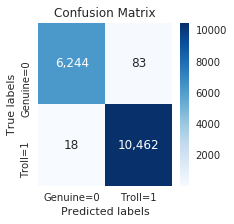

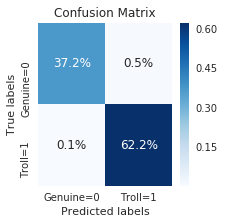

In [38]:
#Print confusion matrix results
sns.set(font_scale=1)  #Change to 3 for exporting
def plot_results_cm(cm):
    fmt = ','
    label_names = ['Genuine=0', 'Troll=1']
    for i in range(2):
        if i == 1:
            cm = cm / np.sum(cm)
            fmt = '.1%'
    
        fig, ax = plt.subplots(figsize=(3, 3))  #Change to 12, 12 for exporting
        sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, ax = ax, fmt=fmt); #annot=True to annotate cells

        #labels, title and ticks
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title('Confusion Matrix'); 
        ax.xaxis.set_ticklabels(label_names); ax.yaxis.set_ticklabels(label_names)

print('CLASSIFICATION REPORT:')
print(classification_report(y_true, y_pred, target_names=['Genuine', 'Russian']))
print('ROC AUC SCORE: {:.1%}'.format(roc_auc_score(y_true, y_pred)))

plot_results_cm(cnf_matrix)
sns.set(font_scale=1)

In [39]:
#Mean Metadata Values
cols = ['retweet_count', 'favorite_count', 'num_hashtags','num_urls','num_mentions',
        'statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'listed_count',
        'seq_len_cantok',
       ]

agg_dict = dict()
for col in cols:
    agg_dict[col] = 'mean'
    
print('Table of Mean Values by Result:')
df_alltweets.groupby(['result']).agg(agg_dict).reset_index()

#Interesting results ... outliers might be dragging up the means, let's try medians next

Table of Mean Values by Result:


,result,num_urls,num_mentions,favourites_count,retweet_count,statuses_count,listed_count,followers_count,seq_len_cantok,friends_count,favorite_count,num_hashtags
0,"False Negative (pred=Genunie, target=Russian)",0.611111,0.500000,3172.611111,2.166667,14662.000000,37.666667,11425.611111,12.666667,612.611111,0.833333,1.055556
1,"False Positive (pred=Russian, target=Genunie)",0.204819,0.590361,673.903614,0.084337,839.542169,8.168675,323.506024,14.072289,357.554217,0.783133,0.337349
2,"True Negative (pred=Genunie, target=Genunie)",0.121717,0.561499,5074.613389,0.242953,24186.693145,37.582159,2484.693786,13.106182,699.930013,0.578475,0.225496
3,"True Positive (pred=Russian, target=Russian)",0.064328,0.010227,2310.037373,9.729975,4405.141751,35.400019,3979.897152,19.074842,3087.877748,8.570159,0.461480


In [40]:
#Median (or whatever quantile you want) Metadata Values
agg_dict = dict()
for col in cols:
    agg_dict[col] = lambda x : x.quantile(0.5)   #0.5 for median
    
print('Table of Median Values by Result:')
metadata_median_by_rslt = df_alltweets.groupby(['result']).agg(agg_dict).reset_index()
metadata_median_by_rslt

Table of Median Values by Result:


,result,num_urls,num_mentions,favourites_count,retweet_count,statuses_count,listed_count,followers_count,seq_len_cantok,friends_count,favorite_count,num_hashtags
0,"False Negative (pred=Genunie, target=Russian)",0.0,0.0,2774.0,0.0,6804.0,23.0,536.0,12.5,514.0,0.0,0.0
1,"False Positive (pred=Russian, target=Genunie)",0.0,0.0,180.0,0.0,563.0,1.0,170.0,13.0,228.0,0.0,0.0
2,"True Negative (pred=Genunie, target=Genunie)",0.0,0.0,1885.0,0.0,11656.0,4.0,514.0,11.0,418.0,0.0,0.0
3,"True Positive (pred=Russian, target=Russian)",0.0,0.0,1657.0,0.0,2010.0,19.0,1704.0,18.0,1555.0,0.0,0.0


In [41]:
def fetch_most_common_tokens(rslt, limit=None):
    '''Get the top most common result tokens from a result type
    '''
    return pd.Series([item for sublist in df_alltweets['text_cantok'][df_alltweets['rslt'] == rslt]
                      for item in sublist]).value_counts()[0:limit]

In [42]:
#Get counts of most common words by result group
rslt_list = ['FP', 'FN', 'TP', 'TN']
for rslt in rslt_list:
    print('\n{}:'.format(rslt))    
    print(fetch_most_common_tokens(rslt, 50))


FP:
<user>       53
.            39
<hashtag>    30
!            28
<allcaps>    27
'            27
<url>        25
the          24
i            20
<repeat>     18
to           18
<number>     17
a            14
,            13
is           11
you          11
-            10
it           10
of           10
and           9
for           9
my            8
on            8
s             8
your          8
just          8
in            8
?             8
from          7
this          6
that          6
so            6
<smile>       6
me            6
not           6
;             5
out           5
&             5
:             5
with          5
at            5
/             5
up            4
have          4
about         4
too           4
t             4
now           4
all           4
)             4
dtype: int64

FN:
<hashtag>             19
<url>                 13
<user>                10
.                      9
<repeat>               6
<allcaps>              6
'                      4
yo

In [43]:
#Eliminate words that happen in all 4 (effectively makes a stop-word list)

#Get lists 0 - limit
limit = 150

#Store lists in dictionary
rslt_top_x = dict()
for rslt in rslt_list:
    rslt_top_x[rslt] = fetch_most_common_tokens(rslt, limit)
    
#Find intersection of all 4 and make a set of it
common_rslts = (set(rslt_top_x['FP'].index.values.tolist()) & 
                set(rslt_top_x['FN'].index.values.tolist()) & 
                set(rslt_top_x['TP'].index.values.tolist()) & 
                set(rslt_top_x['TN'].index.values.tolist())
               )
print('Number of words in common across all 4 result types:', len(common_rslts), '\n')

#Subtract that set from each list and report each list
print('REMAINING WORDS NOT IN COMMON ACROSS ALL 4 LISTS:')
for rslt in rslt_list:
    print('{}:'.format(result_lingo[rslt]))    
    print(rslt_top_x[rslt][~rslt_top_x[rslt].index.isin(list(common_rslts))][0:10])
    print()
    #Notice the ~ operator negates the 'isin' command


Number of words in common across all 4 result types: 31 

REMAINING WORDS NOT IN COMMON ACROSS ALL 4 LISTS:
False Positive (pred=Russian, target=Genunie):
i           20
<number>    17
is          11
it          10
my           8
on           8
your         8
just         8
from         7
this         6
dtype: int64

False Negative (pred=Genunie, target=Russian):
trump                 3
trumpforpresident     3
️                     3
can                   3
he                    2
vote                  2
handle                2
trumppence<number>    2
‼                     2
tcot                  2
dtype: int64

True Positive (pred=Russian, target=Russian):
:           8554
rt          7083
…           2620
<number>    1535
i           1435
is          1413
trump       1037
it           944
on           931
this         681
dtype: int64

True Negative (pred=Genunie, target=Genunie):
i           1901
<number>     728
is           696
it           681
my           619
:            532
me

### Review Preds Distribution; Investigate Errors

/home/brandon_cummings/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


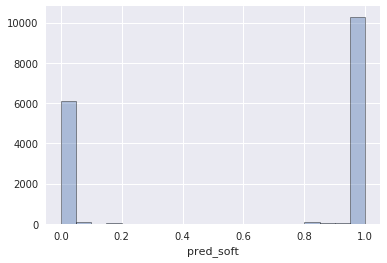

In [44]:
plot_vals = df_alltweets[~df_alltweets['pred_soft'].isnull()]['pred_soft']
hues = df_alltweets[~df_alltweets['pred_soft'].isnull()]['rslt']

#df_alltweets.loc[df_alltweets.index[cutoff_dev_test:cutoff_test_end], 'pred_soft']
plot_vals

sns.distplot(plot_vals, kde=False, bins=20, 
             hist_kws=dict(edgecolor='black', linewidth=1))



Text(0.5,0.98,'Distribution of Softmax Predictions')

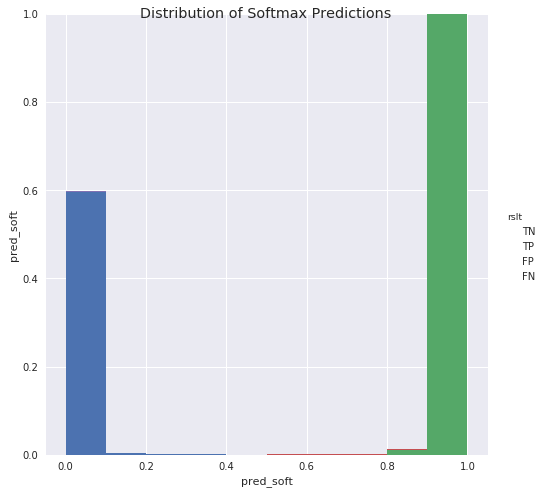

In [45]:
#plt.rcParams['figure.figsize']=(2,2)
g = sns.pairplot(df_alltweets[~df_alltweets['pred_soft'].isnull()],
                 hue='rslt', vars=['pred_soft'], size=7
                )

g.fig.suptitle('Distribution of Softmax Predictions')

#Not sure how to either display correctly or remove the legend (it's pretty obvious)

Above, we observe that the false positives (predicts > 0.5 but target = 0) are a little more prevalent than the false negatives.

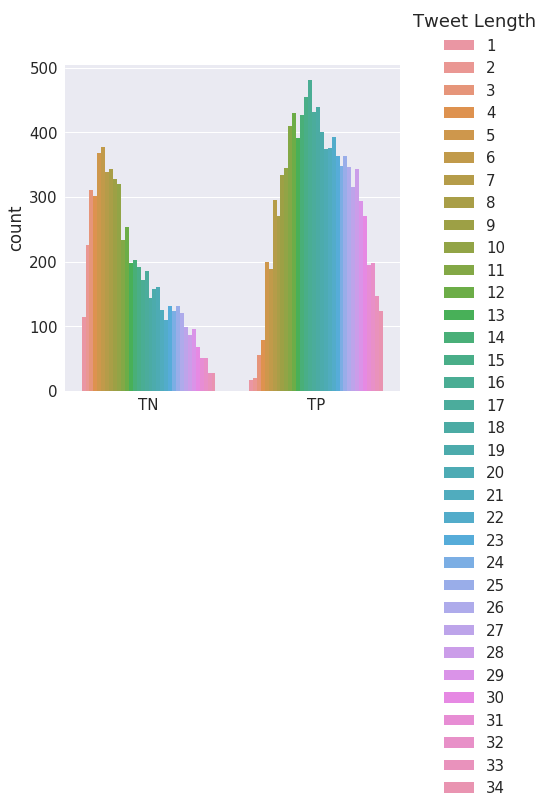

In [46]:
#Tweet length

# hue = rslt
# seq length = category
# bar length = frequency
sns.set(font_scale=1.5)
fig, ax = plt.subplots()
fig.set_size_inches(6,6)
ax = sns.countplot(x='rslt', hue='seq_len_cantok', data=df_alltweets[(df_alltweets['seq_len_cantok'] <= 34) &
                                                                     ((df_alltweets['rslt'] == 'TP') |
                                                                     (df_alltweets['rslt'] == 'TN') )
                                                                    ]
                  )
ax.legend(bbox_to_anchor=(1, 1.2), loc=0, title='Tweet Length')
ax.xaxis.set_label_text('')
#ax.xaxis.set_ticklabels(['True Positives', 'True Negatives'])
sns.set(font_scale=1)

# fig, ax = plt.subplots()
# fig.set_size_inches(14,6)
# ax = sns.countplot(x='rslt', hue='seq_len_cantok', data=df_alltweets[df_alltweets['seq_len_cantok'] <= 34])
# ax.legend(bbox_to_anchor=(1, 1.2), loc=0, title='Tweet Length')

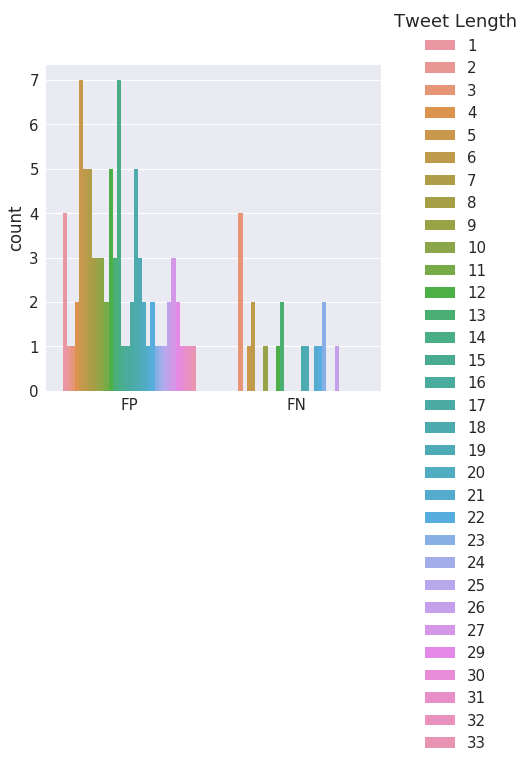

In [47]:
#FP and FN only
sns.set(font_scale=1.5)
fig, ax = plt.subplots()
fig.set_size_inches(6,6)
ax = sns.countplot(x='rslt', hue='seq_len_cantok', data=df_alltweets[(df_alltweets['seq_len_cantok'] <= 34) &
                                                                     ((df_alltweets['rslt'] == 'FP') |
                                                                     (df_alltweets['rslt'] == 'FN') )
                                                                    ]
                  )
ax.legend(bbox_to_anchor=(1, 1.2), loc=0, title='Tweet Length')
ax.xaxis.set_label_text('')
#ax.xaxis.set_ticklabels(['False Negatives', 'False Positives'])
sns.set(font_scale=1)

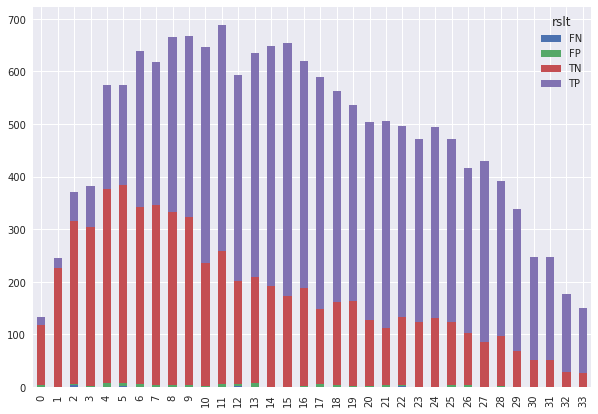

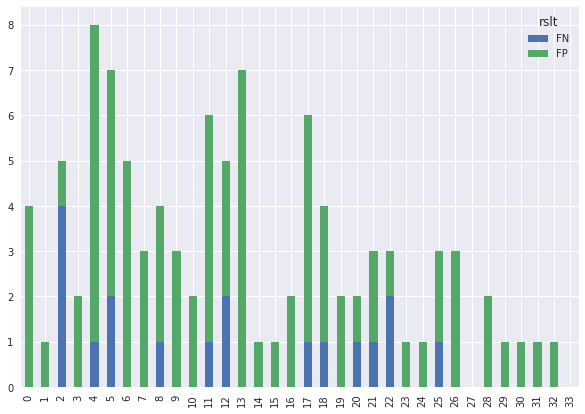

In [48]:
df_plt_data = pd.crosstab(df_alltweets['seq_len_cantok'],df_alltweets['rslt']).reset_index()
df_plt_data = df_plt_data[df_plt_data['seq_len_cantok'] <= 34]
df_plt_data.loc[:,['FN','FP', 'TN','TP']].plot.bar(stacked=True, figsize=(10,7))
df_plt_data.loc[:,['FN','FP']].plot.bar(stacked=True, figsize=(10,7))

True negatives tend to be shorter, but I see no pattern in the rest.

### Inspect actual tweet text of false postives and negatives

In [49]:
#Print out false positives & negatives
pd.set_option('max_colwidth', 10000)  #Prevent ellipsis in cells

cols = ['text', 'text_cantok', 'pred_soft', 'result']

df_alltweets[(df_alltweets['rslt'] == 'FP') & (df_alltweets['pred_soft'] > 0.9)][cols]

,text,text_cantok,pred_soft,result
251781,This new year is going to be crazy,"[this, new, year, is, going, to, be, crazy]",0.985709,"False Positive (pred=Russian, target=Genunie)"
252349,Looks like I'm the DD for my mom since she's at la cocina lol,"[looks, like, i, ', m, the, dd, <allcaps>, for, my, mom, since, she, ', s, at, la, cocina, lol]",0.942678,"False Positive (pred=Russian, target=Genunie)"
252462,@pagursua so expensive.. :)),"[<user>, so, expensive, ., <repeat>, <smile>]",0.957068,"False Positive (pred=Russian, target=Genunie)"
252675,@CurryPapi Follow this guy too! https://t.co/xPwAvb9vmN for bess pics and commentary..,"[<user>, follow, this, guy, too, !, <url>, for, bess, pics, and, commentary, ., <repeat>]",0.934713,"False Positive (pred=Russian, target=Genunie)"
253722,''Started from the bottom now were here''!!!!! :),"[', ', started, from, the, bottom, now, were, here, ', ', !, <repeat>, <smile>]",0.900001,"False Positive (pred=Russian, target=Genunie)"
255062,Just voted,"[just, voted]",0.950885,"False Positive (pred=Russian, target=Genunie)"
256064,http://t.co/rUUW5fDdxN,[<url>],0.988249,"False Positive (pred=Russian, target=Genunie)"
257064,if all goes to plan i should have a video up 2nite,"[if, all, goes, to, plan, i, should, have, a, video, up, <number>nite]",0.998914,"False Positive (pred=Russian, target=Genunie)"
260075,What Austin does in class,"[what, austin, does, in, class]",0.942678,"False Positive (pred=Russian, target=Genunie)"
260719,@ELLEmagazine She already talked about it on @TheEllenShow. https://t.co/skqccMhMQh #toolate,"[<user>, she, already, talked, about, it, on, <user>, ., <url>, <hashtag>, toolate]",0.913911,"False Positive (pred=Russian, target=Genunie)"


In [50]:
pd.set_option('max_colwidth', 200)  #Oddly, this prevents crazy cell heights
df_alltweets[(df_alltweets['rslt'] == 'FN') & (df_alltweets['pred_soft'] < 0.1)][cols]
#df_alltweets[(df_alltweets['rslt'] == 'FN') ]

,text,text_cantok,pred_soft,result
250217,@santanaraymond @yusefsalaam salute Harlem family https://t.co/rJ2fBjdhRo,"[<user>, <user>, salute, harlem, family, <url>]",4.181802e-19,"False Negative (pred=Genunie, target=Russian)"
250948,don't BOO...VOTE‼️‼️ https://t.co/QDlrf6ViYW,"[don, ', t, boo, <allcaps>, ., <repeat>vote, <allcaps>, ‼, ️, ‼, ️, <url>]",4.181802e-19,"False Negative (pred=Genunie, target=Russian)"
251770,If you live in the USA please vote for Trump. You can make a better world for all of us #TrumpPence16 #TrumpForPresident,"[if, you, live, in, the, usa, <allcaps>, please, vote, for, trump, ., you, can, make, a, better, world, for, all, of, us, <hashtag>, trumppence<number>, <hashtag>, trumpforpresident]",2.415941e-02,"False Negative (pred=Genunie, target=Russian)"
252490,Американский политический беженец поздравляет Обаму с днем рождения из Санкт-Петербурга\nhttps://t.co/tOpklObwYE,"[американский, политический, беженец, поздравляет, обаму, с, днем, рождения, из, санкт, -, петербурга, <url>]",0.000000e+00,"False Negative (pred=Genunie, target=Russian)"
257828,@realDonaldTrump bruh you can't even handle AC mobsters and you gonna handle Isis? https://t.co/22UjgqBu1f,"[<user>, bruh, you, can, ', t, even, handle, ac, <allcaps>, mobsters, and, you, gonna, handle, isis, ?, <url>]",4.181802e-19,"False Negative (pred=Genunie, target=Russian)"
258178,"@CBSThisMorning can't wait til he ""grab"" up pence 's piece... @realDonaldTrump #Gump #Mutt https://t.co/FyImPRzPta","[<user>, can, ', t, wait, til, he, "", grab, "", up, pence, ', s, piece, ., <repeat>, <user>, <hashtag>, gump, <hashtag>, mutt, <url>]",4.181802e-19,"False Negative (pred=Genunie, target=Russian)"
261891,@Creflo_Dollar how much @realDonaldTrump post in that direct deposit⁉️ https://t.co/qLw1o6Tqh6,"[<user>, how, much, <user>, post, in, that, direct, deposit, ⁉, ️, <url>]",4.181802e-19,"False Negative (pred=Genunie, target=Russian)"
263372,Где-то на темной стороне... https://t.co/6fGbAy04Ho,"[где, -, то, на, темной, стороне, ., <repeat>, <url>]",0.000000e+00,"False Negative (pred=Genunie, target=Russian)"
265102,Save America Vote TRUMP!#ImVotingBecause #ImWithHer #ElectionDay #election2016 #TrumpPence16 https://t.co/J8FAMGJm2u #TrumpForPresident,"[save, america, vote, trump, <allcaps>, !, <hashtag>, imvotingbecause, <hashtag>, imwithher, <hashtag>, electionday, <hashtag>, election<number>, <hashtag>, trumppence<number>, <url>, <hashtag>, t...",2.415941e-02,"False Negative (pred=Genunie, target=Russian)"
265575,@HillaryClinton #ImNotWithHer,"[<user>, <hashtag>, imnotwithher]",2.415941e-02,"False Negative (pred=Genunie, target=Russian)"


### Is This Just a Political Word Classifier?

Let's hunt for political words in the True Negatives:

In [51]:
df_alltweets[(df_alltweets['target'] == 0) & 
             (df_alltweets['text'].str.contains('donald', case=False))
            ][cols]

,text,text_cantok,pred_soft,result
3204,@Coach_Josh_Penn Lol Hey Coach whatever makes you Happy! What is the book on Janine McDonald? She is a Phoenix now!,"[<user>, lol, hey, coach, whatever, makes, you, happy, !, what, is, the, book, on, janine, mcdonald, ?, she, is, a, phoenix, now, !]",NaN,NaN
5578,@camsbiatch but I think he didnt buy zayn bc he cant he even went to mcdonalds to upload to soundcloud bc free wifi,"[<user>, but, i, think, he, didnt, buy, zayn, bc, he, cant, he, even, went, to, mcdonalds, to, upload, to, soundcloud, bc, free, wifi]",NaN,NaN
7423,And I ate Taco Bell and McDonald's today.,"[and, i, ate, taco, bell, and, mcdonald, ', s, today, .]",NaN,NaN
8511,@ClydeenMcDonald no he has not been called in for screening yet ... but he has written a letter consenting,"[<user>, no, he, has, not, been, called, in, for, screening, yet, ., <repeat>, but, he, has, written, a, letter, consenting]",NaN,NaN
16019,"1. MURDALE MCDONALDS dusty ""I hire everybody that come for an open interview"" messy ass had me fucked up","[<number>, murdale, <allcaps>, mcdonalds, <allcaps>, dusty, "", i, hire, everybody, that, come, for, an, open, interview, "", messy, ass, had, me, fucked, up]",NaN,NaN
27658,@classicqrande @buterarighteous ONLY FOR MY NIGGA DONALd,"[<user>, <user>, only, <allcaps>, for, <allcaps>, my, <allcaps>, nigga, <allcaps>, donal, <allcaps>d]",NaN,NaN
28779,Im eating mcdonalds because im drunk.,"[im, eating, mcdonalds, because, im, drunk, .]",NaN,NaN
29497,Mcdonalds chocolate chip cookies are too flame,"[mcdonalds, chocolate, chip, cookies, are, too, flame]",NaN,NaN
33116,IF YOU WORK IN MCDONALDS WORK THE FUCK OUT THAT MCDONALDS YOU BROKE SCUM DONT BE A MISERABLE FUCK WHO CANT GIVE GOOD CUSTO SERVICE,"[if, <allcaps>, you, <allcaps>, work, <allcaps>, in, <allcaps>, mcdonalds, <allcaps>, work, <allcaps>, the, <allcaps>, fuck, <allcaps>, out, <allcaps>, that, <allcaps>, mcdonalds, <allcaps>, you, ...",NaN,NaN
36722,@ClydeenMcDonald yh we not winning the league. But give me that 2nd,"[<user>, yh, we, not, winning, the, league, ., but, give, me, that, <number>nd]",NaN,NaN


In [52]:
(df_alltweets['target'] == 1) & (df_alltweets['text'].str.contains('trump', case=False))

0         False
1         False
2          True
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23         True
24        False
25        False
26        False
27        False
28         True
29        False
          ...  
266777    False
266778    False
266779    False
266780     True
266781    False
266782    False
266783    False
266784    False
266785     True
266786    False
266787    False
266788     True
266789    False
266790    False
266791    False
266792    False
266793    False
266794    False
266795    False
266796    False
266797    False
266798    False
266799    False
266800    False
266801    False
266802    False
266803    False
266804    False
266805    False
266806    False
Length: 266807, dtype: b

In [53]:
words = ['trump', 'donald', 'hillary', 'clinton', 'bernie', 'sanders', 'obama', 'bush',
         'election', 'vote', '2018', 'polit', 'islam', 'muslim', 'washington', 'president', 
         'country'
        ]
len_troll = sum(df_alltweets['target'] == 1)
len_genuine = sum(df_alltweets['target'] == 0)
print('Number of troll tweets:', len_troll)
print('Number of genuine tweets:', len_genuine)

for word in words:
    print(word.upper(), ':\n', df_alltweets[(df_alltweets['text'].str.contains(word, case=False))]['target'] \
          .value_counts(), sep='')
    print('\n', df_alltweets[(df_alltweets['text'].str.contains(word, case=False))]['target'] \
          .value_counts() / (len_troll, len_genuine), sep='')
    print()

Number of troll tweets: 163810
Number of genuine tweets: 102997
TRUMP:
1    21869
0       24
Name: target, dtype: int64

1    0.133502
0    0.000233
Name: target, dtype: float64

DONALD:
1    5101
0      96
Name: target, dtype: int64

1    0.031140
0    0.000932
Name: target, dtype: float64

HILLARY:
1    7801
0      35
Name: target, dtype: int64

1    0.047622
0    0.000340
Name: target, dtype: float64

CLINTON:
1    6266
0      20
Name: target, dtype: int64

1    0.038252
0    0.000194
Name: target, dtype: float64

BERNIE:
1    647
0      4
Name: target, dtype: int64

1    0.003950
0    0.000039
Name: target, dtype: float64

SANDERS:
1    568
0      5
Name: target, dtype: int64

1    0.003467
0    0.000049
Name: target, dtype: float64

OBAMA:
1    6430
0     136
Name: target, dtype: int64

1    0.039253
0    0.001320
Name: target, dtype: float64

BUSH:
1    471
0     43
Name: target, dtype: int64

1    0.002875
0    0.000417
Name: target, dtype: float64

ELECTION:
1    2698
0     100

In [54]:
#Now let's look to see which contain ANY of these words
unique_tweets = df_alltweets[df_alltweets['text_cantok'].map(set) & set(words)]['target'].value_counts()
print('ALL WORDS:\n', unique_tweets, sep='')
print('\n', unique_tweets / (len_troll, len_genuine), sep='')

"""
#Conclusion:  20% of troll tweets contain these words vs. 1% of genuine tweets.  So while this likely helps predict 
the class for those 20% of tweets, it still leaves 80% to be predicted by other means.
""";

ALL WORDS:
1    32454
0      625
Name: target, dtype: int64

1    0.198120
0    0.006068
Name: target, dtype: float64


In [55]:
#Let's look at the tweets that don't contain these words to see if we can see any patterns.
df_alltweets[(~df_alltweets['text'].str.contains('|'.join(words), case=False)) &
             (df_alltweets['target'] == 1)
            ]

,tweet_id,text,user_id,in_reply_to_status_id,retweeted_status_id,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions,target,statuses_count,followers_count,friends_count,favourites_count,listed_count,text_cantok,embedded_text,seq_len_cantok,pred,pred_soft,result,rslt
4,806301848542003200,RT @thesalteater: wow... https://t.co/R9s9KkLVN9,1680366068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1356.0,571.0,470.0,1365.0,7.0,"[rt, <allcaps>, <user>, :, wow, ., <repeat>, <url>]","[[0.6824300289154053, 0.7358899712562561, 0.017528999596834183, -0.13763000071048737, 0.360289990901947, 0.5170400142669678, 0.19539999961853027, 0.7521899938583374, 0.43029001355171204, 1.0728000...",8,NaN,NaN,NaN,NaN
5,806450264278495232,RT @hervegg: L'étonnante inculture crasse du Journaliste de @lobs qui confond Balthazar avec Belzébuth https://t.co/nK4Eo9P76h,1676481360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2170.0,1909.0,1501.0,1778.0,23.0,"[rt, <allcaps>, <user>, :, l, ', étonnante, inculture, crasse, du, journaliste, de, <user>, qui, confond, balthazar, avec, belzébuth, <url>]","[[0.6824300289154053, 0.7358899712562561, 0.017528999596834183, -0.13763000071048737, 0.360289990901947, 0.5170400142669678, 0.19539999961853027, 0.7521899938583374, 0.43029001355171204, 1.0728000...",19,NaN,NaN,NaN,NaN
7,707744034102583296,More differences in #GOPDebate candidates than #DemDebate with a rich old white man https://t.co/qlBGbh7IB9,1623180199,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,2320.0,1565.0,1586.0,1090.0,18.0,"[more, differences, in, <hashtag>, gopd, <allcaps>ebate, candidates, than, <hashtag>, demdebate, with, a, rich, old, white, man, <url>]","[[0.0500979982316494, -0.0397690013051033, -0.45337000489234924, 0.45028001070022583, 0.40310001373291016, 0.7310699820518494, 0.5708199739456177, -0.22928999364376068, -0.7279800176620483, -0.286...",17,NaN,NaN,NaN,NaN
8,756849533443641344,"RT @cnnbrk: Two ISIS fighters detonated suicide belts in deadly Kabul attack, ISIS' media wing says. https://t.co/1gyuRotPlf",1649487510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1935.0,909.0,859.0,2026.0,13.0,"[rt, <allcaps>, <user>, :, two, isis, <allcaps>, fighters, detonated, suicide, belts, in, deadly, kabul, attack, ,, isis, <allcaps>, ', media, wing, says, ., <url>]","[[0.6824300289154053, 0.7358899712562561, 0.017528999596834183, -0.13763000071048737, 0.360289990901947, 0.5170400142669678, 0.19539999961853027, 0.7521899938583374, 0.43029001355171204, 1.0728000...",24,NaN,NaN,NaN,NaN
9,774255117927350272,US increases military presence in #Iraq by 460 more men in preparation for Mosul offfensive\n\nhttps://t.co/TDwAH17sNs https://t.co/7MskQDZjnq,3899481526,0.0,0.0,15.0,1.0,1.0,1.0,0.0,1,10162.0,26430.0,6100.0,93.0,273.0,"[us, <allcaps>, increases, military, presence, in, <hashtag>, iraq, by, <number>, more, men, in, preparation, for, mosul, offfensive, <url>, <url>]","[[0.5147200226783752, 0.5952699780464172, 0.031088000163435936, 0.311710000038147, 0.09266799688339233, 0.2014400064945221, 0.23416000604629517, 0.41635000705718994, 0.20767000317573547, -0.506380...",19,NaN,NaN,NaN,NaN
10,829952337347219456,RT @BreitbartNews: Never meant to start a war. https://t.co/iVxTeCtinV,2540882036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1396.0,1424.0,1676.0,1011.0,10.0,"[rt, <allcaps>, <user>, :, never, meant, to, start, a, war, ., <url>]","[[0.6824300289154053, 0.7358899712562561, 0.017528999596834183, -0.13763000071048737, 0.360289990901947, 0.5170400142669678, 0.19539999961853027, 0.7521899938583374, 0.43029001355171204, 1.0728000...",12,NaN,NaN,NaN,NaN
11,825196532592959488,"RT @rebeccagberg: Here's what Spicer said, per the pool report. This is basically the border adjustment tax congressional Rs want https://t…",1649144358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1232.0,1519.0,1351.0,592.0,29.0,"[rt, <allcaps>, <user>, :, here, ', s, what, spicer, said, ,, per, the, pool, report, ., this, is, basically, the, border, adjustment, tax, congressional, rs, want, <url>, …]","[[0.6824300289154053, 0.7358899712562561, 0.017528999596834183,

In [56]:
#Let's look at the highest percentage difference between target == 0 vs 1

#Build dictionary
token_dict_0 = defaultdict(float)
token_dict_1 = defaultdict(float)

# len_troll = sum(df_alltweets['target'] == 1)
# len_genuine = sum(df_alltweets['target'] == 0)

for df_row in df_alltweets[df_alltweets['target'] == 0].itertuples():
    temp_dict = defaultdict(int)
    for token in df_row.text_cantok:
        temp_dict[token]
    for k in temp_dict:
        token_dict_0[k] += 1 / len_genuine
        
for df_row in df_alltweets[df_alltweets['target'] == 1].itertuples():
    temp_dict = defaultdict(int)
    for token in df_row.text_cantok:
        temp_dict[token]
    for k in temp_dict:
        token_dict_1[k] += 1 / len_troll

token_dict_diff = {key: token_dict_1[key] - token_dict_0.get(key, 0) for key in token_dict_1.keys()}

#Reverse option (results appears nearly, if not exactly, identical)
#token_dict_diff = {key: token_dict_0[key] - token_dict_1.get(key, 0) for key in token_dict_0.keys()}

In [57]:
test_word = 'rt'
print('WORD = {}, GENUINE: {:.2%}, TROLL: {:.2%}, DIFFERENCE: {:.2%}'.format(test_word,
                                                                             token_dict_0[test_word],
                                                                             token_dict_1[test_word],
                                                                             token_dict_diff[test_word]
                                                                            ))

WORD = rt, GENUINE: 1.15%, TROLL: 66.17%, DIFFERENCE: 65.02%


In [58]:
od = sorted(token_dict_diff.items(), key = itemgetter(1), reverse = True)

#Alternate method, but we don't really need it to be an OrderedDict
#od = OrderedDict(sorted(token_dict_diff.items(), key = itemgetter(1), reverse = True))

od

[('rt', 0.6501982368236824),
 (':', 0.6193438845013491),
 ('<allcaps>', 0.5693844612553092),
 ('<hashtag>', 0.37714509975293775),
 ('<url>', 0.34647168301113795),
 ('…', 0.23808231225699159),
 ('<user>', 0.2297649352466617),
 ('trump', 0.09642187264084201),
 ('the', 0.07021427508690106),
 ('to', 0.062467095326953714),
 ('of', 0.056656015254882355),
 ('-', 0.05126788800302256),
 ('in', 0.05003189920939448),
 ('s', 0.04646731836702979),
 (',', 0.03867898909746173),
 ('’', 0.03408639455471894),
 ('hillary', 0.03150107628681341),
 ('obama', 0.031107550434851985),
 ('clinton', 0.03091834390195978),
 ('"', 0.028718417447396803),
 ('for', 0.027343560971764685),
 ('is', 0.024003398917124386),
 ('politics', 0.023636747807338633),
 ('<number>', 0.021710285245582273),
 ('news', 0.02000193259357037),
 ('on', 0.019880672076217992),
 ('by', 0.01921833200463103),
 ('amp', 0.018394424251391456),
 (';', 0.017149106417115145),
 ('our', 0.01706084779800146),
 ('donald', 0.016878791184456034),
 ('we', 0.0

In [59]:
#Show in reverse order:
od[::-1]

[('i', -0.12308024939660243),
 ('my', -0.042186886115493996),
 ('me', -0.039800490572800246),
 ('<repeat>', -0.03799237475531289),
 ('<smile>', -0.030718704187413827),
 ('so', -0.026156195280653428),
 ('<elong>', -0.025117230793713058),
 ('m', -0.024425447395407533),
 ('you', -0.022952420339422394),
 ('?', -0.022916590906011725),
 ('!', -0.02218901541431359),
 ('lol', -0.01766066583064943),
 ('it', -0.016608317285965013),
 ('just', -0.01473975648786863),
 ('like', -0.012319917366796187),
 ('love', -0.010628149116122932),
 ('good', -0.010326155662385239),
 ('na', -0.010183302842596755),
 ('but', -0.00994184932004925),
 ('haha', -0.009851216107171901),
 ('de', -0.009149485719114888),
 ('que', -0.008239226715012812),
 ('oh', -0.008116279136025719),
 ('hahaha', -0.008089466805117646),
 ('today', -0.008018509043208671),
 ('“', -0.007936913914451801),
 ('too', -0.00792407312564093),
 ('<sadface>', -0.007779006393098734),
 ('im', -0.007711701382753372),
 ('ko', -0.0067766044503799585),
 ('got

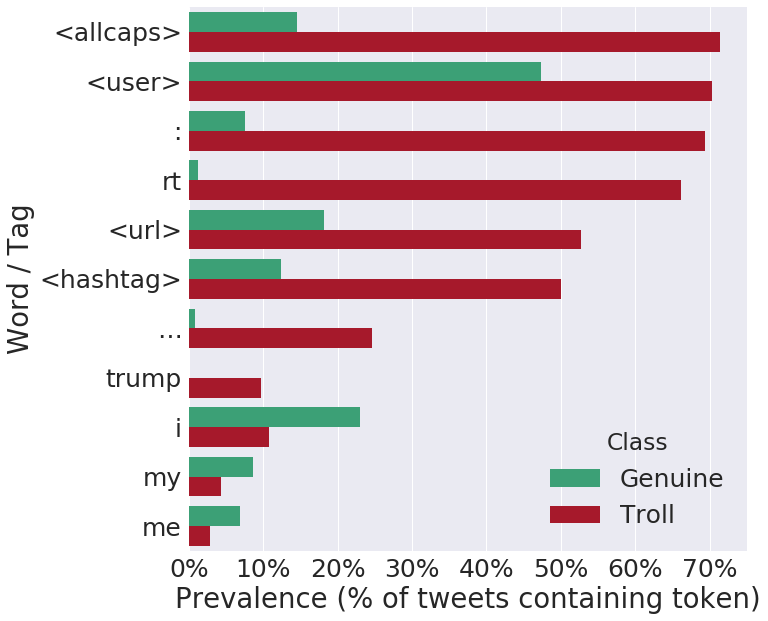

In [60]:
#Let's graph this (use a bar graph)

#Build data
diff_words = ['<allcaps>', '<user>', ':', 'rt', '<url>', '<hashtag>', '…', 'trump', 'i', 'my', 'me']

df_plot = pd.DataFrame(columns=['Genuine', 'Troll'], index=diff_words)

for word in diff_words:
    df_plot.loc[word, 'Genuine'] = token_dict_0[word]
    df_plot.loc[word, 'Troll'] = token_dict_1[word]
df_plot.reset_index(inplace=True)


plot_data = pd.melt(df_plot, id_vars=['index'], value_vars=['Genuine', 'Troll'])

plot_data.rename(index=str, columns={'index': 'Word', 'variable': 'Class', 'value': 'Prevalence'}, inplace=True)


sns.set(font_scale=2.5)
fig, ax = plt.subplots()
fig.set_size_inches(10,10)

newPal   = dict(Genuine = '4878CF', Troll = '4878CF')

ax = sns.barplot(data=plot_data, y='Word', x='Prevalence', hue='Class', palette=['#2bb179', '#be0119'])
#sns.diverging_palette(133, 10, n=2)
ax.set_xlabel('Prevalence (% of tweets containing token)')
ax.set_ylabel('Word / Tag')
ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
ax.set_xticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%'])

sns.set(font_scale=1)

In [61]:
#Let's re-evaluate all tweets with the most common tags ...
#words = ['rt', ':', '<allcaps>', '<hashtag>', '<url>', '…', '<user>', 'trump']
words = ['rt', ':', '<allcaps>', '<hashtag>', '<url>', '…', 'trump']
words = ['rt', ':', '<allcaps>', 'trump']

unique_tweets = df_alltweets[df_alltweets['text_cantok'].map(set) & set(words)]['target'].value_counts()

print('ALL WORDS:\n', unique_tweets, sep='')
print('\n', unique_tweets / (len_troll, len_genuine), sep='')

ALL WORDS:
1    126185
0     20386
Name: target, dtype: int64

1    0.770313
0    0.197928
Name: target, dtype: float64


### Inspect Unknown Embeddings

In [62]:
#Load unknown embedding
unk_embed = np.load('data/GloVe_Unknown_50.npy')
unk_embed

array([-0.75581  ,  0.65351  ,  0.017113 , -0.46716  , -0.41164  ,
       -0.15223  , -0.32018  ,  0.13096  , -0.47702  ,  0.30387  ,
       -0.49072  ,  0.49712  , -0.76242  , -0.75837  ,  0.15845  ,
        0.12721  ,  0.26129  ,  0.061279 , -0.44009  ,  0.23058  ,
       -0.82653  ,  0.073613 ,  0.25677  , -0.35542  ,  0.32554  ,
        0.71409  ,  0.94323  , -0.018156 , -0.55853  ,  0.88851  ,
        0.070136 ,  0.012131 ,  0.37727  ,  0.06488  , -0.53939  ,
        0.22079  , -0.40003  ,  0.55029  ,  0.85582  , -0.078582 ,
       -0.34651  ,  0.71381  ,  1.0456   , -0.79633  , -1.1146   ,
        0.0019505,  0.28528  , -0.33569  ,  0.40309  , -0.54987  ])

In [63]:
#Count most common unknown words
df_alltweets[~df_alltweets['rslt'].isnull()]  #Remember ~ negates

unk_dict = dict()
unk_dict['TP'] = defaultdict(int)
unk_dict['TN'] = defaultdict(int)
unk_dict['FP'] = defaultdict(int)
unk_dict['FN'] = defaultdict(int)

#For each df_row ...
for df_row in df_alltweets[~df_alltweets['rslt'].isnull()].itertuples():
    #print(df_row.embedded_text)
    unk_count = 0
    for i, embed_row in enumerate(df_row.embedded_text):
        if np.allclose(embed_row, unk_embed):
            unk_dict[df_row.rslt][df_row.text_cantok[i]] += 1
            unk_count += 1
    
    df_alltweets.loc[df_alltweets.index[df_row.Index], 'unk_count'] = unk_count

unk_dict

{'FN': defaultdict(int,
             {'<repeat>indiana': 1,
              '<repeat>vote': 1,
              'discri': 1,
              'election<number>': 1,
              'electionday': 1,
              'hillaryforprison': 1,
              'imnotwithher': 1,
              'imvotingbecause': 1,
              'imwithher': 1,
              'prayers<number>cali': 1,
              'sanbernardinoshooting': 1,
              'trumpforpresident': 3,
              'trumppence<number>': 2,
              'беженец': 1,
              '‼': 2,
              '⁉': 1,
              '️': 3}),
 'FP': defaultdict(int,
             {'<allcaps>logger': 1,
              '<allcaps>vspak': 1,
              '<number>am': 1,
              '<number>km': 1,
              '<number>nite': 1,
              '<repeat>or': 1,
              '<repeat>so': 1,
              'addawordruinamovie': 1,
              'athleticismatitsbest': 1,
              'bloggerswanted': 1,
              'cometoplay': 1,
              'edu<num

In [64]:
df_alltweets[~df_alltweets['rslt'].isnull()]

,tweet_id,text,user_id,in_reply_to_status_id,retweeted_status_id,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions,target,statuses_count,followers_count,friends_count,favourites_count,listed_count,text_cantok,embedded_text,seq_len_cantok,pred,pred_soft,result,rslt,unk_count
250000,583795877501767681,@ArianaGrande please babeeeee,552147716,0.000000e+00,0.0,0.0,0.0,0.0,0.0,1.0,0,9565.0,2850.0,1777.0,572.0,2.0,"[<user>, please, babe, <elong>]","[[0.7870399951934814, 0.7215099930763245, 0.29148000478744507, -0.05652699992060661, 0.31683000922203064, 0.47172001004219055, 0.023460999131202698, 0.6956800222396851, 0.20781999826431274, 0.6098...",4,0.0,1.779011e-04,"True Negative (pred=Genunie, target=Genunie)",TN,0.0
250001,890373430221996032,RT @MixAffiliates: Tee Munee ft. Jetes - Many (Video) https://t.co/RMYi9yPu4r via @MixAffiliates @teemuneemusic,1768259989,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,1978.0,914.0,847.0,1996.0,23.0,"[rt, <allcaps>, <user>, :, tee, munee, ft, ., jetes, -, many, (, video, ), <url>, via, <user>, <user>]","[[0.6824300289154053, 0.7358899712562561, 0.017528999596834183, -0.13763000071048737, 0.360289990901947, 0.5170400142669678, 0.19539999961853027, 0.7521899938583374, 0.43029001355171204, 1.0728000...",18,1.0,9.967816e-01,"True Positive (pred=Russian, target=Russian)",TP,1.0
250002,817997461029523456,RT @WyzeChef: I used to jam that Les Nubians album on repeat and I didn't understand a single word of it.,1617939218,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,1906.0,908.0,1075.0,1983.0,5.0,"[rt, <allcaps>, <user>, :, i, used, to, jam, that, les, nubians, album, on, repeat, and, i, didn, ', t, understand, a, single, word, of, it, .]","[[0.6824300289154053, 0.7358899712562561, 0.017528999596834183, -0.13763000071048737, 0.360289990901947, 0.5170400142669678, 0.19539999961853027, 0.7521899938583374, 0.43029001355171204, 1.0728000...",26,1.0,9.979575e-01,"True Positive (pred=Russian, target=Russian)",TP,0.0
250003,560950046569820163,@katelynkuehl obviously the love note didn't work.. #nowimsad,174935239,5.609475e+17,0.0,0.0,1.0,1.0,0.0,1.0,0,9086.0,255.0,300.0,5586.0,1.0,"[<user>, obviously, the, love, note, didn, ', t, work, ., <repeat>, <hashtag>, nowimsad]","[[0.7870399951934814, 0.7215099930763245, 0.29148000478744507, -0.05652699992060661, 0.31683000922203064, 0.47172001004219055, 0.023460999131202698, 0.6956800222396851, 0.20781999826431274, 0.6098...",13,0.0,1.897040e-08,"True Negative (pred=Genunie, target=Genunie)",TN,1.0
250004,802176809609625601,RT @lamentefugitiva: Inside the Activistz Studio Returnz https://t.co/4wtWzO6Mop via @moorbey,1659549972,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,1811.0,824.0,874.0,2145.0,17.0,"[rt, <allcaps>, <user>, :, inside, the, activistz, studio, returnz, <url>, via, <user>]","[[0.6824300289154053, 0.7358899712562561, 0.017528999596834183, -0.13763000071048737, 0.360289990901947, 0.5170400142669678, 0.19539999961853027, 0.7521899938583374, 0.43029001355171204, 1.0728000...",12,1.0,9.988550e-01,"True Positive (pred=Russian, target=Russian)",TP,2.0
250005,708698194331340800,Raise your voice against govt’s efforts to fitter #InternetFreedom #NoCyberCensorship,2540882036,0.000000e+00,0.0,0.0,0.0,1.0,0.0,0.0,1,1396.0,1424.0,1676.0,1011.0,10.0,"[raise, your, voice, against, govt, ’, s, efforts, to, fitter, <hashtag>, internetfreedom, <hashtag>, nocybercensorship]","[[-0.3911600112915039, 0.6202499866485596, -0.03000199981033802, 0.03764000162482262, 0.5259400010108948, -0.3122299909591675, 0.37386998534202576, 0.29096999764442444, 0.1252399981021881, -0.3852...",14,1.0,9.998703e-01,"True Positive (pred=Russian, target=Russian)",TP,2.0
250006,477334674474160128,141828663RB006_General_View https://t.co/0JcNZghPaR,505959713,0.000000e+00,0.0,0.0,0.0,0.0,1.0,0.0,0,4252.0,295.0,427.0,114.0,22.0,"[<number>rb, <allcaps><number>_general_view, <url>]","[[-0.755810022354126, 0.6535099744796753, 0.01711300015449524, -0.4671599864959717, -0.4116399884223938, -0.1522299945354461

In [65]:

for rslt in unk_dict:
    print(rslt)
    print(OrderedDict(sorted(unk_dict[rslt].items(), key = itemgetter(1), reverse = True)))
    print('\n\n\n')

TN
OrderedDict([('️', 64), ('<allcaps><number>', 31), ('<number><number>', 13), ('<number>th', 13), ('<allcaps>s', 13), ('<number>am', 12), ('<repeat><hashtag>', 10), ('<number>pm', 9), ('<number>k', 8), ('<number>st', 8), ('x<number>', 8), ('<repeat>i', 6), ('偽<number>ch騒動', 6), ('偽<number>ch問題', 6), ('<number>s', 5), ('<number>m', 5), ('<repeat>and', 5), ('<number><number><number>', 5), ('<number>nd', 4), ('<number>d', 4), ('methats', 4), ('s<number>', 4), ('<number>gb', 4), ('spooniechat', 4), ('neriumad', 4), ('<repeat>that', 3), ('【', 3), ('<repeat>it', 3), ('<number>yrs', 3), ('p<number>', 3), ('<repeat>but', 3), ('sizzler<number>', 3), ('xx<number>', 3), ('〜', 3), ('simondanczuk', 3), ('<allcaps><user>', 3), ('a<number>', 3), ('neverbealoneatmidnight', 3), ('votetrismtv', 3), ('<number>ers', 3), ('vote<number>sos', 3), ('<repeat>lol', 3), ('<repeat>not', 3), ('<repeat>we', 3), ('】', 3), ('<repeat>go', 3), ('<repeat>you', 2), ('<number>yo', 2), ('emilybeautifulrickards', 2), ('<r

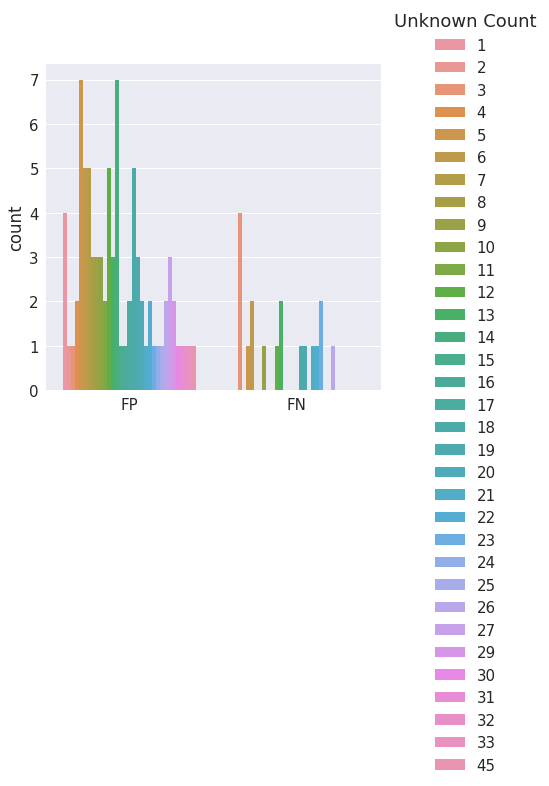

In [66]:
#Tweet length

# hue = rslt
# seq length = category
# bar length = frequency
sns.set(font_scale=1.5)
fig, ax = plt.subplots()
fig.set_size_inches(6,6)
ax = sns.countplot(x='rslt', hue='seq_len_cantok', data=df_alltweets[(df_alltweets['unk_count'] <= 34) &
                                                                     ((df_alltweets['rslt'] == 'FP') |
                                                                     (df_alltweets['rslt'] == 'FN') )
                                                                    ]
                  )
ax.legend(bbox_to_anchor=(1, 1.2), loc=0, title='Unknown Count')
ax.xaxis.set_label_text('')
#ax.xaxis.set_ticklabels(['True Positives', 'True Negatives'])
sns.set(font_scale=1)

#Of note, these can be longer than cutoff_length (currently 40, 99.5 percentile) because embeddings 
#aren't trimmed (or padded) in the dataframe.